In [97]:
import codecs
import random
from collections import Counter, defaultdict
from math import log
from random import randint

import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from scipy.optimize import curve_fit
from tqdm import tqdm

In [98]:
FONT_SIZE = 16
RANDOM_SEED = 42
matplotlib.rcParams.update({'font.size': FONT_SIZE})

# Задача 7

In [99]:
def generate_buckley_osthus_graph(n, m, a):
    G1mn = generate_simple_buckley_osthus_graph(m * n, a)
    G = nx.MultiDiGraph()
    for u, v in tqdm(G1mn.edges(), miniters=len(G1mn.edges()) // 100, total=len(G1mn.edges())):
        u_new, v_new = u // m, v // m
        G.add_edge(u_new, v_new)
    return G

In [100]:
def generate_simple_buckley_osthus_graph(n, a):
    simple_buckley_osthus_graph = nx.MultiDiGraph()
    simple_buckley_osthus_graph.add_edge(0, 0)
    node_degree2node_ids_list = {2 : [0,], 1: list()}
    node_degree_2node_count = Counter({2 : 1, 1: 0})

    weights = np.zeros(shape=n, dtype=float)
    weights[0] = 2 + a - 1
    for i in tqdm(range(1, n), total=n, miniters=n // 1000):
        new_node_id = simple_buckley_osthus_graph.number_of_nodes()
        simple_buckley_osthus_graph.add_node(new_node_id)
        node_degrees = list(node_degree_2node_count.keys())
        degrees = []
        weights = []
        for j, node_deg in enumerate(node_degrees):
            degrees.append(node_deg)
            num_nodes_given_degree = node_degree_2node_count[node_deg]
            weights.append(num_nodes_given_degree * (node_deg + a - 1))
        degrees.append(-1)
        weights.append(a)

        randomed_degree = random.choices(degrees, weights=weights)[0]

        if randomed_degree == -1:
            destination_node_id = new_node_id
            node_degree_2node_count[2] += 1
            node_degree2node_ids_list[2].append(new_node_id)
        else:

            destination_node_id = random.choice(node_degree2node_ids_list[randomed_degree])
            node_degree2node_ids_list[randomed_degree].remove(destination_node_id)
            if node_degree2node_ids_list.get(randomed_degree + 1) is None:
                node_degree2node_ids_list[randomed_degree + 1] = []
            node_degree2node_ids_list[randomed_degree + 1].append(destination_node_id)
            node_degree_2node_count[randomed_degree] -= 1
            node_degree_2node_count[randomed_degree + 1] += 1
            node_degree_2node_count[1] += 1
            node_degree2node_ids_list[1].append(new_node_id)
        simple_buckley_osthus_graph.add_edge(new_node_id, destination_node_id)


    return simple_buckley_osthus_graph


In [101]:
m = 2
n = 5000
a = 0.27
buckley_osthus_graph = generate_buckley_osthus_graph(n, m, a)

100%|██████████| 10000/10000 [00:00<00:00, 373042.56it/s]


In [102]:
buckley_osthus_graph.number_of_nodes()

5000

In [103]:
degrees = defaultdict(int)
for v in buckley_osthus_graph.nodes():
    deg = buckley_osthus_graph.degree(v)
    degrees[deg] += 1
x = sorted(degrees.keys())
empyrical_degrees_distribution = [degrees[deg] for deg in x]


In [104]:
def beta_a_m_d(a, m, d):
    beta_num = scipy.special.beta(d - m + m * a, a + 2, )
    beta_denom = scipy.special.beta(m * a, a + 1, )
    return beta_num / beta_denom

In [105]:
theoretical_degrees_distrib = [n * beta_a_m_d(a, m, d) for d in x]
for i in range(len(theoretical_degrees_distrib)):
    if theoretical_degrees_distrib[i] < 1:
        theoretical_degrees_distrib = theoretical_degrees_distrib[:i]
        break


## Сравнение теоретического и эмпирического распределений степеней вершин

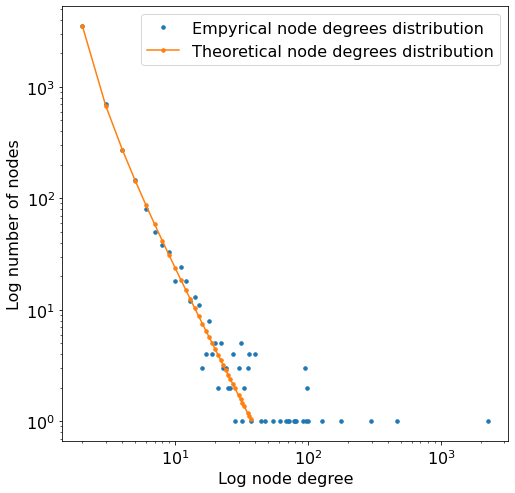

In [106]:
plt.figure(figsize=(8, 8), )
plt.loglog(x, empyrical_degrees_distribution, ls='None', marker='.', markersize=7, label="Empyrical node degrees distribution")
plt.loglog(x[:len(theoretical_degrees_distrib)], theoretical_degrees_distrib, marker='.', markersize=7,
           label="Theoretical node degrees distribution")
plt.xlabel("Log node degree", )
plt.ylabel("Log number of nodes")
plt.legend()
plt.show()

## Проверка быстроты генерации графа при n=10000 и m=5

**Генерируется быстрее, чем за минуту**

In [107]:
m = 5
n = 10000
a = 0.27
buckley_osthus_graph = generate_buckley_osthus_graph(n, m, a)

100%|██████████| 50000/50000 [00:00<00:00, 71100.24it/s]


In [108]:
# raise Exception

# Задача 8

In [109]:
def load_edges_list(input_graph_edges_path):
    edges_list = []
    with codecs.open(input_graph_edges_path, 'r') as inp_file:
        for line in inp_file:
            nodes = line.strip().split('\t')
            source_node = int(nodes[0])
            target_node = int(nodes[1])
            edges_list.append((source_node, target_node))
    return edges_list

In [110]:
input_graph_edges_path = "graph.txt"
edges_list = load_edges_list(input_graph_edges_path)

In [111]:
edges_list[:3]

[(0, 1), (1, 2), (2, 0)]

In [112]:
def initialize_graph(start_edges):
    input_degrees = Counter()
    output_degrees = Counter()
    nodes_set = set()
    for (source_node, target_node) in start_edges:
        if output_degrees.get(target_node) is None:
            output_degrees[target_node] = 0
        if input_degrees.get(source_node) is None:
            input_degrees[source_node] = 0
        output_degrees[source_node] += 1
        input_degrees[target_node] += 1
        nodes_set.add(source_node)
        nodes_set.add(target_node)
    return input_degrees, output_degrees, nodes_set

In [113]:
def calculate_graph_likelihood(added_edges, input_degrees, output_degrees, nodes_set, delta_in, delta_out, alpha, beta,
                               gamma):
    likelihood_sum = 0
    for t, (source_node, target_node) in enumerate(added_edges):
        t += 3
        num_nodes = len(nodes_set)
        if source_node in nodes_set and target_node in nodes_set:
            source_node_output_degree = output_degrees[source_node]
            target_node_input_degree = input_degrees[target_node]
            source_node_p = (source_node_output_degree + delta_out) / (t - 1 + delta_out * num_nodes)
            target_node_p = (target_node_input_degree + delta_in) / (t - 1 + delta_in * num_nodes)
            edge_probability = beta * source_node_p * target_node_p
        elif source_node in nodes_set and target_node not in nodes_set:
            source_node_output_degree = output_degrees[source_node]
            source_node_p = (source_node_output_degree + delta_out) / (num_nodes - 1 + delta_out * num_nodes)
            edge_probability = gamma * source_node_p
        elif target_node in nodes_set and source_node not in nodes_set:
            target_node_input_degree = input_degrees[target_node]
            target_node_p = (target_node_input_degree + delta_in) / (t - 1 + delta_in * num_nodes)
            edge_probability = alpha * target_node_p
        else:
            raise Exception("Edge error")
        input_degrees[target_node] += 1
        output_degrees[source_node] += 1
        nodes_set.add(source_node)
        nodes_set.add(target_node)
        log_likelihood = log(edge_probability, )
        likelihood_sum += log_likelihood
    return likelihood_sum / len(added_edges)

In [114]:
delta_out = 0
# delta_in = 0.5
alpha = 0.5
beta = 0.5
gamma = 0
start_edges, added_edges = edges_list[:3], edges_list[3:]

In [115]:
input_degrees, output_degrees, nodes_set = initialize_graph(start_edges)

### Граф зависимости логарифма правдоподобия от $\delta_{in}$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


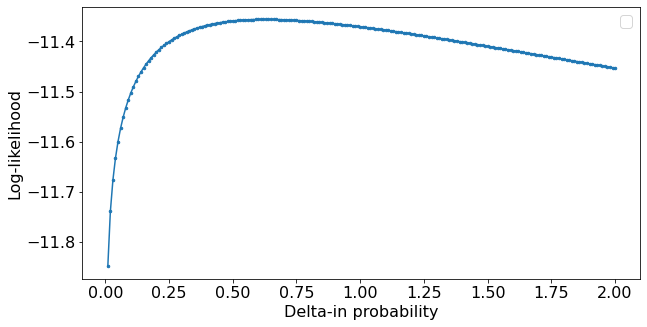

In [116]:
likelihoods_list = []
delta_ins_range = np.arange(0.01, 2.01, 0.01)
for delta_in in delta_ins_range:
    input_degrees, output_degrees, nodes_set = initialize_graph(start_edges)
    # print(len(nodes_set), len(input_degrees.keys()), len(output_degrees.keys()))
    likelihood = calculate_graph_likelihood(added_edges=added_edges, input_degrees=input_degrees,
                                            output_degrees=output_degrees, nodes_set=nodes_set, delta_in=delta_in,
                                            delta_out=delta_out, alpha=alpha, beta=beta, gamma=gamma)
    likelihoods_list.append(likelihood)
plt.figure(figsize=(10, 5), )
plt.plot(delta_ins_range, likelihoods_list, marker='.', markersize=5)
plt.xlabel("Delta-in probability", )
plt.ylabel("Log-likelihood")
plt.legend()
plt.show()


### Нахождение оптимального значения $\delta_{in}$ с точностью до 10e-4

In [117]:
max_likelihood = -np.inf
best_delta_in = None
delta_ins_range = np.arange(0.25, 1.01, 0.0001)
for delta_in in delta_ins_range:
    input_degrees, output_degrees, nodes_set = initialize_graph(start_edges)
    likelihood = calculate_graph_likelihood(added_edges=added_edges, input_degrees=input_degrees,
                                            output_degrees=output_degrees, nodes_set=nodes_set, delta_in=delta_in,
                                            delta_out=delta_out, alpha=alpha, beta=beta, gamma=gamma)
    if likelihood > max_likelihood:
        max_likelihood = likelihood
        best_delta_in = delta_in

In [118]:
print(f"Оптимальное значение delta_in: {best_delta_in}")

Оптимальное значение delta_in: 0.6268999999999585


# Задача 9

In [119]:
graph_edges = [(0, 1)]
edge_degrees = {0: 1, 1: 1}
num_iterations = 100000
num_deg_2_nodes = 0
num_deg_2_nodes_history = []
for t in tqdm(range(2, num_iterations), miniters=num_iterations // 100):
    num_deg_2_nodes_history.append(num_deg_2_nodes / t)
    num_edges = len(graph_edges)
    edge_id = randint(0, num_edges - 1)
    (node_id_1, node_id_2) = graph_edges[edge_id]
    edge_degrees[t] = 2
    num_deg_2_nodes += 1
    if edge_degrees[node_id_1] == 1:
        num_deg_2_nodes += 1
    if edge_degrees[node_id_2] == 1:
        num_deg_2_nodes += 1
    if edge_degrees[node_id_1] == 2:
        num_deg_2_nodes -= 1
    if edge_degrees[node_id_2] == 2:
        num_deg_2_nodes -= 1

    edge_degrees[node_id_1] += 1
    edge_degrees[node_id_2] += 1

    edge_1 = (t, node_id_1)
    edge_2 = (t, node_id_2)
    graph_edges.append(edge_1)
    graph_edges.append(edge_2)



100%|██████████| 99998/99998 [00:00<00:00, 515338.96it/s]


### Доля вершин степени 2

**Доля вершин степени 2 есть 0.5 от общего количества вершин**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


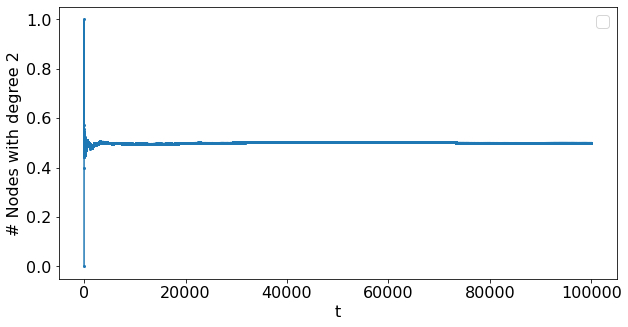

In [120]:
plt.figure(figsize=(10, 5), )
plt.plot(range(2, num_iterations), num_deg_2_nodes_history, marker='.', markersize=4)
plt.xlabel("t", )
plt.ylabel("# Nodes with degree 2")
plt.legend()
plt.show()
